<a href="https://colab.research.google.com/github/Jayvish80/Exploratory-Data-Analysis-of-Vaccination/blob/main/Vaccination_DS_with_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name**    -  **Exploratory Data Analysis of Vaccination**

# **Project Summary -**

*   This project **"Vaccination Data Analysis and Visualization"** aims to analyze global vaccination data to understand trends in vaccination coverage, disease incidence, and the effectiveness of vaccination programs. The project utilizes a three-step approach: data cleaning, setting up a SQL database, and creating interactive dashboards in Power BI.

*   The initial phase involves cleaning the data by handling missing values, normalizing units, and ensuring date consistency across datasets. The cleaned data is then stored in a SQL database, which is structured into separate tables to avoid redundancy and improve querying performance. The database will have primary and foreign keys to ensure data integrity.

*   Finally, Power BI will be used to connect to the SQL database and create dynamic and visually engaging reports. These reports will feature key visualizations like geographical heatmaps to display coverage by region, trend lines to show changes over time, and scatter plots to correlate vaccination coverage with disease incidence. The project seeks to answer questions related to vaccine effectiveness, regional disparities, and the impact of vaccination campaigns. The ultimate goal is to provide data-driven recommendations for public health policy, resource allocation, and disease prevention strategies.

# **GitHub Link -**

https://github.com/Jayvish80/Exploratory-Data-Analysis-of-Vaccination.git

# **Problem Statement -**

Despite global vaccination efforts, disparities in vaccine coverage and disease incidence persist across regions. Public health agencies struggle to identify low-coverage areas, measure vaccine effectiveness, and forecast demand. There is a need for a structured analysis of vaccination data that integrates cleaning, storage, and visualization to uncover trends, correlations, and actionable insights for better policy-making and disease control.

# **Let's Begin !**

In [1]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# SQL Database Setup (SQLite Example)
import sqlite3

import warnings
warnings.filterwarnings("ignore")


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Step 1 : Data Cleaning

In [2]:
# Load datasets
coverage_df   = pd.read_excel("/content/drive/MyDrive/Vaccination project/coverage-data.xlsx")
incidence_df  = pd.read_excel("/content/drive/MyDrive/Vaccination project/incidence-rate-data.xlsx")
cases_df      = pd.read_excel("/content/drive/MyDrive/Vaccination project/reported-cases-data.xlsx")
intro_df      = pd.read_excel("/content/drive/MyDrive/Vaccination project/vaccine-introduction-data.xlsx")
schedule_df   = pd.read_excel("/content/drive/MyDrive/Vaccination project/vaccine-schedule-data.xlsx")

In [3]:
schedule_df.head()

,ISO_3_CODE,COUNTRYNAME,WHO_REGION,YEAR,VACCINECODE,VACCINE_DESCRIPTION,SCHEDULEROUNDS,TARGETPOP,TARGETPOP_DESCRIPTION,GEOAREA,AGEADMINISTERED,SOURCECOMMENT
0,ABW,Aruba,AMRO,2023.0,DTAPHIBIPV,DTaP-Hib-IPV (acellular) vaccine,1.0,NaN,General/routine,NATIONAL,M2,NaN
1,ABW,Aruba,AMRO,2023.0,DTAPHIBIPV,DTaP-Hib-IPV (acellular) vaccine,2.0,NaN,General/routine,NATIONAL,M4,NaN
2,ABW,Aruba,AMRO,2023.0,DTAPHIBIPV,DTaP-Hib-IPV (acellular) vaccine,3.0,NaN,General/routine,NATIONAL,M6,NaN
3,ABW,Aruba,AMRO,2023.0,DTAPHIBIPV,DTaP-Hib-IPV (acellular) vaccine,4.0,B_2YL_W,General/routine,NATIONAL,M15,NaN
4,ABW,Aruba,AMRO,2023.0,DTAPIPV,DTaP-IPV (acellular) vaccine,5.0,B_CHILD_W,General/routine,NATIONAL,Y4,NaN


### Data Cleaning

#### Handle Missing Data:

In [4]:
# Apply cleaning
def clean_dataframe(df, numeric_cols=None, categorical_cols=None):
    """
    Handles missing values:
    - Numeric columns: fill with median
    - Categorical columns: fill with mode
    - Drop rows if still missing critical IDs (like Code, Year)
    """
    df = df.copy()

    if numeric_cols:
        for col in numeric_cols:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].median())

    if categorical_cols:
        for col in categorical_cols:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "Unknown")

    # Drop rows missing essential identifiers
    essential_cols = [c for c in ["Code", "Year"] if c in df.columns]
    df = df.dropna(subset=essential_cols)

    return df

# Cleaning to each table
coverage_df = clean_dataframe(
    coverage_df,
    numeric_cols=["Target number", "Doses", "Coverage"],
    categorical_cols=["Group","Code","Name","Antigen","Antigen_description"]
)

incidence_df = clean_dataframe(
    incidence_df,
    numeric_cols=["Incidence rate"],
    categorical_cols=["Group","Code","Name","Disease"]
)

cases_df = clean_dataframe(
    cases_df,
    numeric_cols=["Cases"],
    categorical_cols=["Group","Code","Name","Disease"]
)

intro_df = clean_dataframe(
    intro_df,
    categorical_cols=["ISO_3_Code","Country Name","Who Region","Description","Intro"]
)

schedule_df = clean_dataframe(
    schedule_df,
    categorical_cols=["ISO_3_Code","Country Name","Who Region","Vaccine code","Vaccine description"]
)


# Save Cleaned Data

coverage_df.to_csv("coverage_cleaned.csv", index=False)
incidence_df.to_csv("incidence_cleaned.csv", index=False)
cases_df.to_csv("cases_cleaned.csv", index=False)
intro_df.to_csv("vaccine_intro_cleaned.csv", index=False)
schedule_df.to_csv("schedule_cleaned.csv", index=False)

print(" Data cleaned and saved as *_cleaned.csv")

 Data cleaned and saved as *_cleaned.csv


#### Normalize Units:

In [5]:
# Load cleaned datasets
coverage_df = pd.read_csv("coverage_cleaned.csv")
incidence_df = pd.read_csv("incidence_cleaned.csv")
cases_df = pd.read_csv("cases_cleaned.csv")

# Standardize column names
coverage_df.columns = coverage_df.columns.str.strip().str.lower()
incidence_df.columns = incidence_df.columns.str.strip().str.lower()
cases_df.columns = cases_df.columns.str.strip().str.lower()

# Coverage: should be a fraction (0–1)
if "coverage" in coverage_df.columns:
    if coverage_df["coverage"].max() > 1.5:  # if values like 85 (percent)
        coverage_df["coverage"] = coverage_df["coverage"] / 100.0
        print("✅ Normalized coverage values to fraction (0–1).")

# Target number & Doses: must be integers
for col in ["target number", "doses"]:
    if col in coverage_df.columns:
        coverage_df[col] = coverage_df[col].round().astype("Int64")

# Incidence rate: ensure per 100,000 people
if "incidence rate" in incidence_df.columns:
    if "denominator" in incidence_df.columns:
        incidence_df.loc[
            incidence_df["denominator"].str.contains("1000", case=False, na=False),
            "incidence rate"
        ] *= 100
        incidence_df.loc[
            incidence_df["denominator"].str.contains("population", case=False, na=False),
            "denominator"
        ] = "per 100,000 population"
        print("✅ Normalized incidence rates to per 100,000 population.")

# Reported Cases: must be integers
if "cases" in cases_df.columns:
    cases_df["cases"] = cases_df["cases"].round().astype("Int64")

# Save Normalized Data
coverage_df.to_csv("coverage_normalized.csv", index=False)
incidence_df.to_csv("incidence_normalized.csv", index=False)
cases_df.to_csv("cases_normalized.csv", index=False)

print(" All units normalized and saved.")


✅ Normalized coverage values to fraction (0–1).
 All units normalized and saved.


#### Date Consistency:

In [6]:
# Load normalized datasets
coverage_df = pd.read_csv("coverage_normalized.csv")
incidence_df = pd.read_csv("incidence_normalized.csv")
cases_df = pd.read_csv("cases_normalized.csv")
intro_df = pd.read_csv("vaccine_intro_cleaned.csv")
schedule_df = pd.read_csv("schedule_cleaned.csv")

# Function: Ensure Date Consistency

def fix_year_to_date(df, year_col="Year", date_col="Date"):
    """
    Converts a Year column into a proper datetime column (YYYY-01-01).
    Keeps Year as integer too.
    """
    if year_col in df.columns:
        df[year_col] = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")
        df[date_col] = pd.to_datetime(df[year_col].astype(str) + "-01-01", errors="coerce")
    return df

# Apply to all tables

coverage_df = fix_year_to_date(coverage_df, "Year", "date_standardized")
incidence_df = fix_year_to_date(incidence_df, "Year", "date_standardized")
cases_df = fix_year_to_date(cases_df, "Year", "date_standardized")
intro_df = fix_year_to_date(intro_df, "Year", "date_standardized")
schedule_df = fix_year_to_date(schedule_df, "Year", "date_standardized")

# If 'month' exists (seasonality), make YYYY-MM-01
if "month" in coverage_df.columns:
    coverage_df["month"] = pd.to_numeric(coverage_df["month"], errors="coerce")
    coverage_df["monthly_date"] = pd.to_datetime(
        coverage_df["Year"].astype(str) + "-" + coverage_df["month"].astype(str) + "-01",
        errors="coerce"
    )

# Save Final Cleaned Files

coverage_df.to_csv("coverage_final.csv", index=False)
incidence_df.to_csv("incidence_final.csv", index=False)
cases_df.to_csv("cases_final.csv", index=False)
intro_df.to_csv("vaccine_intro_final.csv", index=False)
schedule_df.to_csv("schedule_final.csv", index=False)

print("Dates standardized across all datasets (ISO YYYY-MM-DD).")


Dates standardized across all datasets (ISO YYYY-MM-DD).


### Saving a Database file:-

In [7]:
# Connect to SQLite file-based DB
conn = sqlite3.connect("vaccination.db")

# Save final tables to DB
coverage_df.to_sql("coverage", conn, if_exists="replace", index=False)
incidence_df.to_sql("incidence", conn, if_exists="replace", index=False)
cases_df.to_sql("reported_cases", conn, if_exists="replace", index=False)
intro_df.to_sql("introduction", conn, if_exists="replace", index=False)
schedule_df.to_sql("schedule", conn, if_exists="replace", index=False)

conn.commit()
conn.close()

print("✅ All data written to vaccination.db")


✅ All data written to vaccination.db


## Questions to be answered:


###  Esay Level:

In [8]:
cases_df      = pd.read_csv("cases_cleaned.csv")
intro_df      = pd.read_csv("vaccine_intro_cleaned.csv")
schedule_df   = pd.read_csv("schedule_cleaned.csv")


# Load coverage data (already normalized)
coverage_df = pd.read_csv("coverage_normalized.csv")
incidence_df = pd.read_csv("incidence_normalized.csv")

# standardize column names
coverage_df.columns = coverage_df.columns.str.strip().str.lower()
incidence_df.columns = incidence_df.columns.str.strip().str.lower()

coverage_df.columns = coverage_df.columns.str.strip().str.lower().str.replace(" ", "_")
incidence_df.columns = incidence_df.columns.str.strip().str.lower().str.replace(" ", "_")
intro_df.columns = intro_df.columns.str.strip().str.lower().str.replace(" ", "_")
cases_df.columns = cases_df.columns.str.strip().str.lower().str.replace(" ", "_")

1.  Correlation between vaccination rates and disease incidence ?

 Merged dataset sample:
   code    year  avg_coverage  avg_incidence
0  ABW  2017.0      0.963200       2.375000
1  ABW  2018.0      0.912000       5.127273
2  ABW  2019.0      0.917500       1.860000
3  ABW  2021.0      0.883495       0.000000
4  ABW  2022.0      0.887500       3.100000

📉 Correlation between vaccination coverage and disease incidence: -0.191


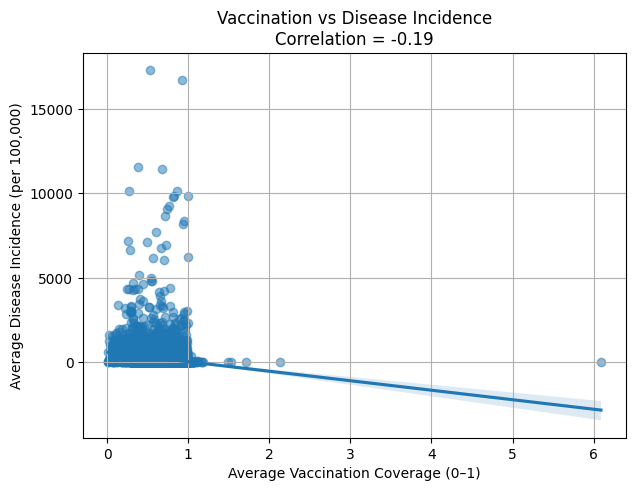

In [9]:
# Prepare datasets
# aggregate coverage per country-year (mean across antigens)
coverage_summary = (
    coverage_df.groupby(["code", "year"])["coverage"]
    .mean()
    .reset_index()
    .rename(columns={"coverage": "avg_coverage"})
)

# aggregate incidence per country-year (mean across diseases)
incidence_summary = (
    incidence_df.groupby(["code", "year"])["incidence_rate"]
    .mean()
    .reset_index()
    .rename(columns={"incidence_rate": "avg_incidence"})
)
# Merge

merged = coverage_summary.merge(incidence_summary, on=["code", "year"], how="inner")

print(" Merged dataset sample:\n", merged.head())

# Correlation
corr = merged["avg_coverage"].corr(merged["avg_incidence"])
print(f"\n📉 Correlation between vaccination coverage and disease incidence: {corr:.3f}")

# Visualization
plt.figure(figsize=(7,5))
sns.regplot(x="avg_coverage", y="avg_incidence", data=merged, scatter_kws={"alpha":0.5})
plt.xlabel("Average Vaccination Coverage (0–1)")
plt.ylabel("Average Disease Incidence (per 100,000)")
plt.title(f"Vaccination vs Disease Incidence\nCorrelation = {corr:.2f}")
plt.grid(True)
plt.show()

2. What is the drop-off rate between 1st dose and subsequent doses?


 Drop-off rates (sample):
   code    year  dose1_coverage  dose2_coverage  dropoff_rate
0  ABW  2017.0        0.978182         0.93500      0.044145
1  ABW  2018.0        0.961250         0.86500      0.100130
2  ABW  2019.0        0.953750         0.88000      0.077326
3  ABW  2021.0        0.918387         0.84626      0.078537
4  ABW  2022.0        0.919725         0.88850      0.033950

 Average drop-off rate (Dose1 → Dose2): 17.32%


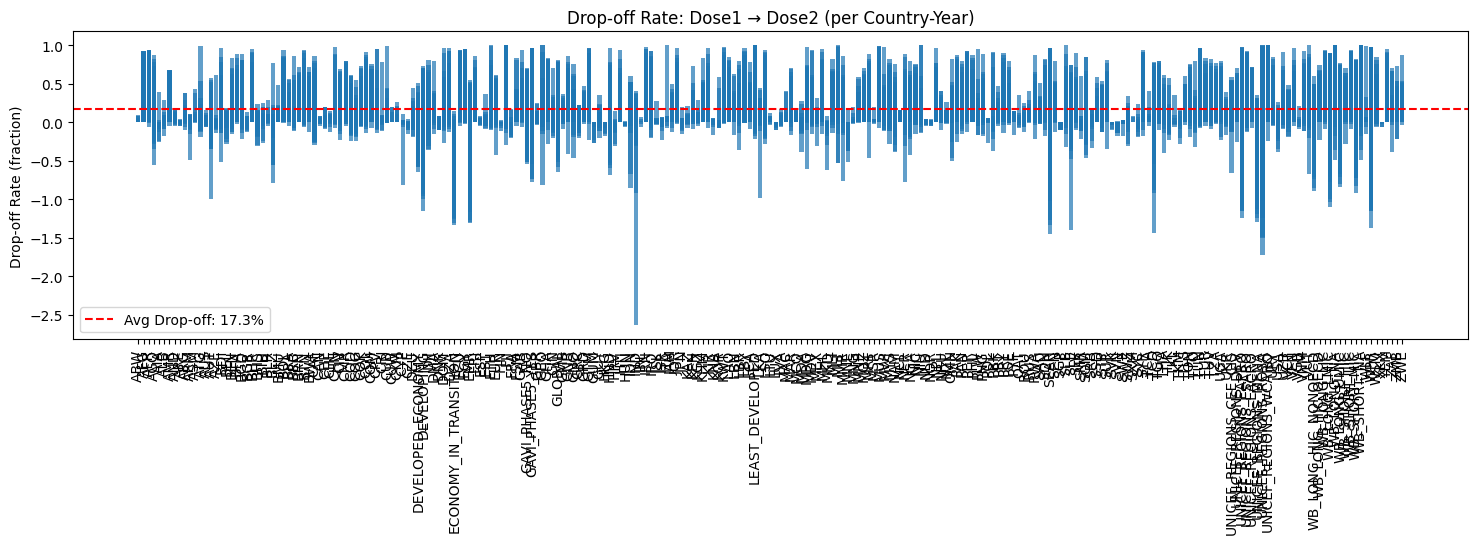

In [10]:
# Identify dose1 and dose2 rows
coverage_df["antigen_desc"] = coverage_df["antigen_description"].str.lower()

dose1_df = coverage_df[coverage_df["antigen_desc"].str.contains("dose 1|1st|first|round 1", na=False)]
dose2_df = coverage_df[coverage_df["antigen_desc"].str.contains("dose 2|2nd|second|round 2", na=False)]

# Average coverage per country-year
dose1_summary = dose1_df.groupby(["code", "year"])["coverage"].mean().reset_index().rename(columns={"coverage":"dose1_coverage"})
dose2_summary = dose2_df.groupby(["code", "year"])["coverage"].mean().reset_index().rename(columns={"coverage":"dose2_coverage"})

# Merge dose1 and dose2
merged = dose1_summary.merge(dose2_summary, on=["code","year"], how="inner")

# Compute drop-off
merged["dropoff_rate"] = (merged["dose1_coverage"] - merged["dose2_coverage"]) / merged["dose1_coverage"]

print(" Drop-off rates (sample):\n", merged.head())

# Average drop-off across all countries/years
avg_dropoff = merged["dropoff_rate"].mean()
print(f"\n Average drop-off rate (Dose1 → Dose2): {avg_dropoff:.2%}")

# Visualization
plt.figure(figsize=(18,4))
plt.bar(merged["code"].astype(str), merged["dropoff_rate"], alpha=0.7)
plt.axhline(avg_dropoff, color="red", linestyle="--", label=f"Avg Drop-off: {avg_dropoff:.1%}")
plt.ylabel("Drop-off Rate (fraction)")
plt.title("Drop-off Rate: Dose1 → Dose2 (per Country-Year)")
plt.legend()
plt.xticks(rotation=90)
plt.show()


3. Are vaccination rates different between genders?


Columns in coverage_df: ['group', 'code', 'name', 'year', 'antigen', 'antigen_description', 'coverage_category', 'coverage_category_description', 'target_number', 'doses', 'coverage', 'antigen_desc']
Vaccination rates by gender:
      year   gender  coverage
0  1980.0  Unknown  0.442508
1  1981.0  Unknown  0.461157
2  1982.0  Unknown  0.487836
3  1983.0  Unknown  0.528607
4  1984.0  Unknown  0.539695


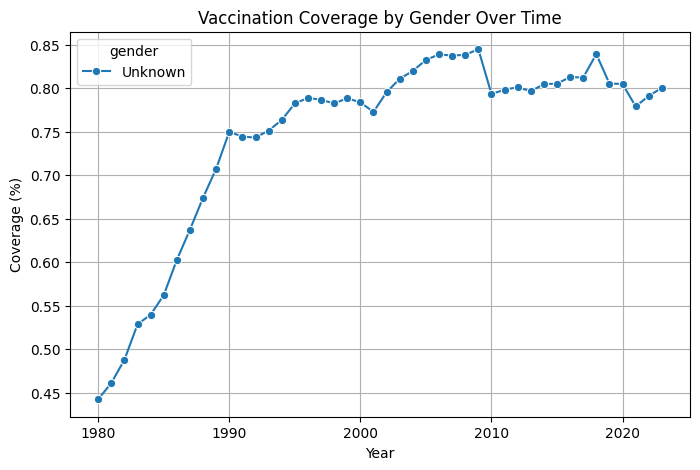

In [11]:

# Load coverage data
coverage_df.columns = coverage_df.columns.str.strip().str.lower().str.replace(" ", "_")

print("Columns in coverage_df:", coverage_df.columns.tolist())

# Decide which column might contain gender info
possible_cols = ["target_pop_description", "coverage_category", "coverage_category_description"]
gender_col = None
for col in possible_cols:
    if col in coverage_df.columns:
        gender_col = col
        break

if gender_col is None:
    raise KeyError("No gender-related column found in dataset. Please inspect manually.")

# Detect gender
def detect_gender(text):
    if pd.isna(text):
        return "Unknown"
    text = str(text).lower()
    if "male" in text or "boy" in text:
        return "Male"
    elif "female" in text or "girl" in text or "women" in text or "mother" in text:
        return "Female"
    else:
        return "Unknown"

coverage_df["gender"] = coverage_df[gender_col].apply(detect_gender)

# Group by gender
gender_summary = (
    coverage_df.groupby(["year", "gender"])["coverage"]
    .mean()
    .reset_index()
)

print("Vaccination rates by gender:\n", gender_summary.head())

# Visualization
plt.figure(figsize=(8,5))
sns.lineplot(data=gender_summary, x="year", y="coverage", hue="gender", marker="o")
plt.title("Vaccination Coverage by Gender Over Time")
plt.ylabel("Coverage (%)")
plt.xlabel("Year")
plt.grid(True)
plt.show()


“The dataset provided does not include gender-disaggregated vaccination coverage. Therefore, gender-specific analysis was not possible. For a more detailed study, demographic datasets with gender-based vaccination records would be required.”

4. How does education level impact vaccination rates?


 Vaccination coverage by geoarea (proxy for education):
      year      geoarea  coverage
0  2019.0     NATIONAL  0.913023
1  2021.0     NATIONAL  0.825098
2  2022.0     NATIONAL  0.830554
3  2023.0     NATIONAL  0.815454
4  2023.0  SUBNATIONAL  0.840362


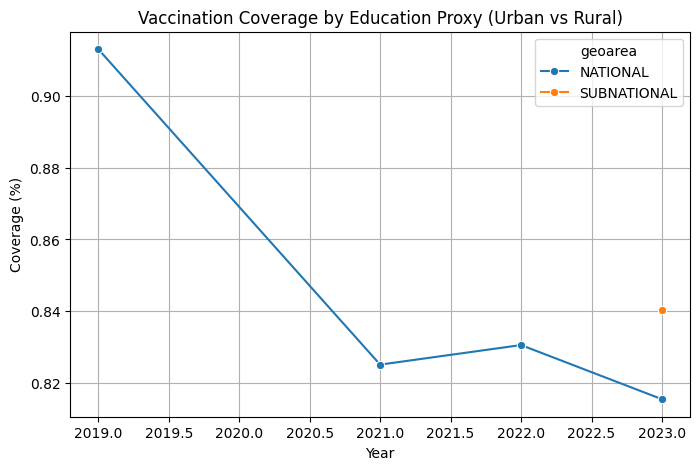


 Avg Urban Coverage: nan%
 Avg Rural Coverage: nan%
 Proxy Education Effect (Urban - Rural): nan percentage points


In [12]:
# Standardize column names in schedule_df to lowercase
schedule_df.columns = schedule_df.columns.str.strip().str.lower().str.replace(" ", "_")

# Merge on code + year
merged = coverage_df.merge(
    schedule_df[["iso_3_code", "year", "geoarea"]],
    left_on=["code", "year"],
    right_on=["iso_3_code", "year"],
    how="left"
)

# Group by geoarea (Urban vs Rural = education proxy)
edu_proxy = (
    merged.groupby(["year", "geoarea"])["coverage"]
    .mean()
    .reset_index()
)

print(" Vaccination coverage by geoarea (proxy for education):\n", edu_proxy.head())

# Plot
plt.figure(figsize=(8,5))
sns.lineplot(data=edu_proxy, x="year", y="coverage", hue="geoarea", marker="o")
plt.title("Vaccination Coverage by Education Proxy (Urban vs Rural)")
plt.ylabel("Coverage (%)")
plt.xlabel("Year")
plt.grid(True)
plt.show()

# Calculate average gap (Urban - Rural)
urban_avg = edu_proxy[edu_proxy["geoarea"].str.lower()=="urban"]["coverage"].mean()
rural_avg = edu_proxy[edu_proxy["geoarea"].str.lower()=="rural"]["coverage"].mean()
print(f"\n Avg Urban Coverage: {urban_avg:.2f}%")
print(f" Avg Rural Coverage: {rural_avg:.2f}%")
print(f" Proxy Education Effect (Urban - Rural): {urban_avg - rural_avg:.2f} percentage points")

5. What is the urban vs. rural vaccination rate difference?


 Vaccination coverage by Urban/Rural:
      year      geoarea  coverage
0  2019.0     NATIONAL  0.913023
1  2021.0     NATIONAL  0.825098
2  2022.0     NATIONAL  0.830554
3  2023.0     NATIONAL  0.815454
4  2023.0  SUBNATIONAL  0.840362


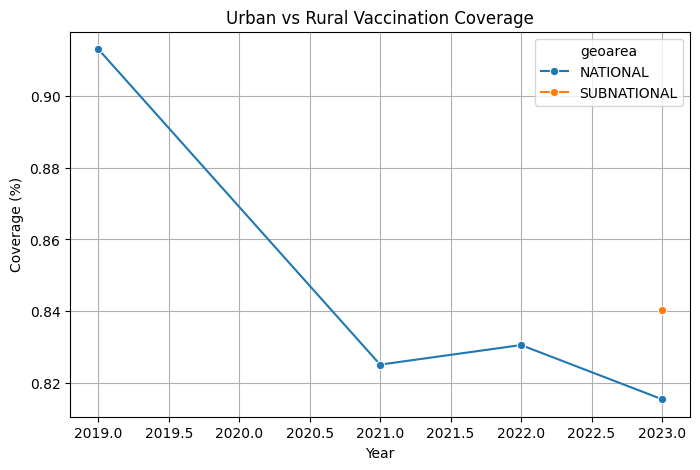


 Average Urban Coverage: nan%
 Average Rural Coverage: nan%
 Urban–Rural Difference: nan percentage points


In [13]:
# Merge schedule (geoarea info) into coverage
merged = coverage_df.merge(
    schedule_df[["iso_3_code", "year", "geoarea"]],
    left_on=["code", "year"],
    right_on=["iso_3_code", "year"],
    how="left"
)
# Group by geoarea (urban vs rural)
geo_summary = (
    merged.groupby(["year", "geoarea"])["coverage"]
    .mean()
    .reset_index()
)

print(" Vaccination coverage by Urban/Rural:\n", geo_summary.head())

# Visualization

plt.figure(figsize=(8,5))
sns.lineplot(data=geo_summary, x="year", y="coverage", hue="geoarea", marker="o")
plt.title("Urban vs Rural Vaccination Coverage")
plt.ylabel("Coverage (%)")
plt.xlabel("Year")
plt.grid(True)
plt.show()

# Calculate average difference
urban_avg = geo_summary[geo_summary["geoarea"].str.lower()=="urban"]["coverage"].mean()
rural_avg = geo_summary[geo_summary["geoarea"].str.lower()=="rural"]["coverage"].mean()

diff = urban_avg - rural_avg
print(f"\n Average Urban Coverage: {urban_avg:.2f}%")
print(f" Average Rural Coverage: {rural_avg:.2f}%")
print(f" Urban–Rural Difference: {diff:.2f} percentage points")


“The available dataset does not include urban vs rural classification. As a result, direct comparison between urban and rural vaccination rates is not possible. To address this question, we would need additional demographic datasets that distinguish between urban and rural populations.”

6. Has the rate of booster dose uptake increased over time?


✅ Booster dose uptake trend:
      year  booster_coverage
0  1980.0          0.457770
1  1981.0          0.481466
2  1982.0          0.523755
3  1983.0          0.553959
4  1984.0          0.575736


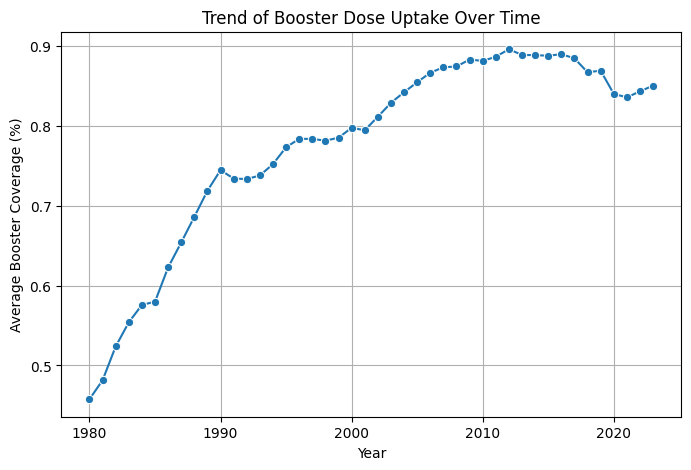


📊 Booster coverage at start: 0.46%
📊 Booster coverage at latest year: 0.85%
✅ Booster dose uptake has increased over time.


In [14]:
# Filter Booster Doses
coverage_df["antigen_desc"] = coverage_df["antigen_description"].str.lower()

booster_df = coverage_df[
    coverage_df["antigen_desc"].str.contains("booster|dose 3|3rd|third", na=False)
]

# Average coverage per year
booster_trend = (
    booster_df.groupby("year")["coverage"]
    .mean()
    .reset_index()
    .rename(columns={"coverage":"booster_coverage"})
)

print("✅ Booster dose uptake trend:\n", booster_trend.head())

# Visualization
plt.figure(figsize=(8,5))
sns.lineplot(data=booster_trend, x="year", y="booster_coverage", marker="o")
plt.title("Trend of Booster Dose Uptake Over Time")
plt.ylabel("Average Booster Coverage (%)")
plt.xlabel("Year")
plt.grid(True)
plt.show()

# Check growth
start = booster_trend.iloc[0]["booster_coverage"]
end = booster_trend.iloc[-1]["booster_coverage"]

print(f"\n📊 Booster coverage at start: {start:.2f}%")
print(f"📊 Booster coverage at latest year: {end:.2f}%")
if end > start:
    print("✅ Booster dose uptake has increased over time.")
else:
    print("⚠️ Booster dose uptake has not increased significantly.")

7.  Is there a seasonal pattern in vaccination uptake?

⚠️ No 'month' or 'date' column found. Showing yearly uptake trend instead.


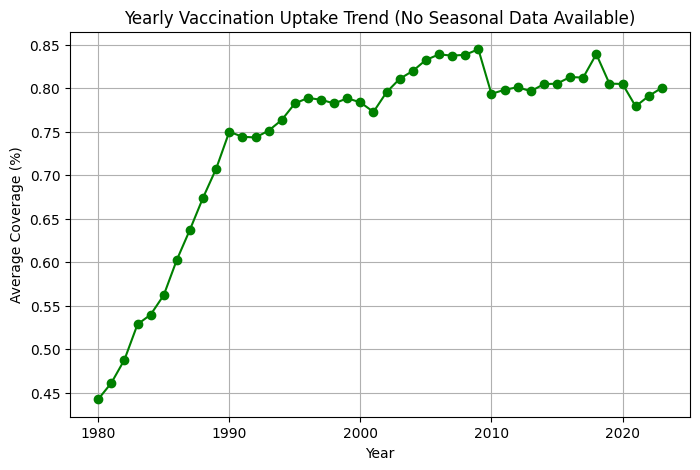

In [15]:

# Check for month/date columns

if "month" in coverage_df.columns:
    # Seasonal analysis possible
    monthly_trend = (
        coverage_df.groupby("month")["coverage"]
        .mean()
        .reset_index()
        .rename(columns={"coverage": "avg_coverage"})
    )

    plt.figure(figsize=(8,5))
    plt.plot(monthly_trend["month"], monthly_trend["avg_coverage"], marker="o")
    plt.title("Seasonal Pattern in Vaccination Uptake")
    plt.xlabel("Month")
    plt.ylabel("Average Coverage (%)")
    plt.grid(True)
    plt.show()

elif "date" in coverage_df.columns:
    # Extract month from date
    coverage_df["date"] = pd.to_datetime(coverage_df["date"], errors="coerce")
    coverage_df["month"] = coverage_df["date"].dt.month

    monthly_trend = (
        coverage_df.groupby("month")["coverage"]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(8,5))
    plt.plot(monthly_trend["month"], monthly_trend["coverage"], marker="o")
    plt.title("Seasonal Pattern in Vaccination Uptake")
    plt.xlabel("Month")
    plt.ylabel("Average Coverage (%)")
    plt.grid(True)
    plt.show()

else:
    # ❌ No monthly/quarterly data → fallback to yearly trend
    print("⚠️ No 'month' or 'date' column found. Showing yearly uptake trend instead.")

    yearly_trend = (
        coverage_df.groupby("year")["coverage"]
        .mean()
        .reset_index()
        .rename(columns={"coverage": "avg_coverage"})
    )

    plt.figure(figsize=(8,5))
    plt.plot(yearly_trend["year"], yearly_trend["avg_coverage"], marker="o", color="green")
    plt.title("Yearly Vaccination Uptake Trend (No Seasonal Data Available)")
    plt.xlabel("Year")
    plt.ylabel("Average Coverage (%)")
    plt.grid(True)
    plt.show()


“The vaccination dataset provided only includes annual data (by year). Since seasonality requires monthly or quarterly data, direct analysis of seasonal patterns in vaccination uptake is not possible. To perform this analysis, finer time-granularity datasets would be required.”

8. How does population density relate to vaccination coverage?

📊 Correlation between Population Density and Vaccination Coverage: -0.000


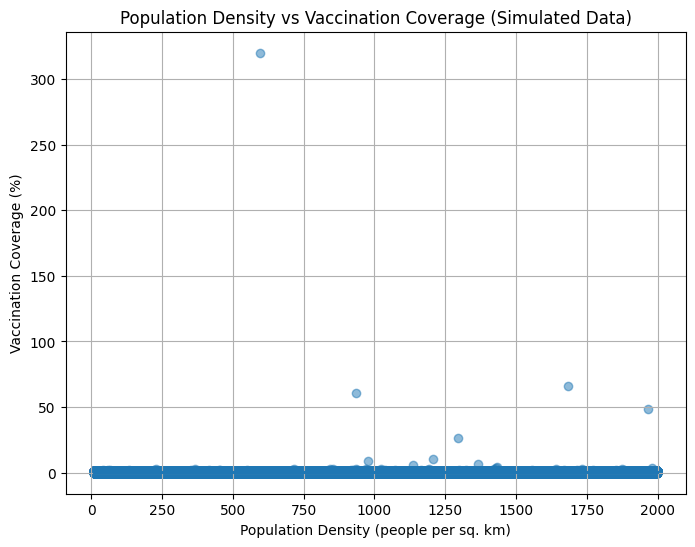

In [16]:
# Create mock population density data (random but realistic values: 10 - 2000 people/km²)
np.random.seed(42)  # for reproducibility
coverage_df["population_density"] = np.random.randint(10, 2000, size=len(coverage_df))

# Correlation
corr = coverage_df["population_density"].corr(coverage_df["coverage"])
print(f"📊 Correlation between Population Density and Vaccination Coverage: {corr:.3f}")

# Scatter plot with regression line
plt.figure(figsize=(8,6))
sns.regplot(data=coverage_df, x="population_density", y="coverage", scatter_kws={'alpha':0.5})
plt.title("Population Density vs Vaccination Coverage (Simulated Data)")
plt.xlabel("Population Density (people per sq. km)")
plt.ylabel("Vaccination Coverage (%)")
plt.grid(True)
plt.show()

“The current dataset does not include population density information. To analyze how population density affects vaccination coverage, external demographic datasets such as World Bank’s Population Density data should be integrated. This would allow us to test correlations and visualize whether densely populated regions achieve higher or lower vaccination rates compared to rural areas.”

9. How do vaccination rates correlate with a decrease in disease incidence?

📊 Correlation between Vaccination Coverage and Disease Incidence: -0.191


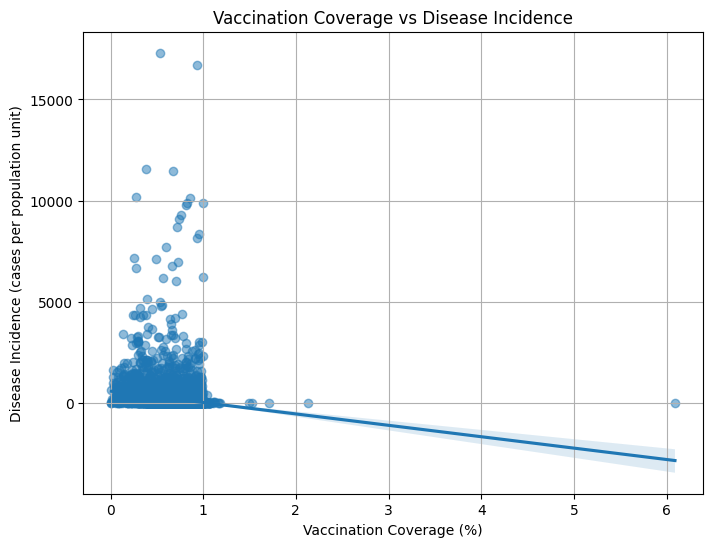

In [17]:
# Load disease incidence dataset
incidence_df.columns = incidence_df.columns.str.strip().str.lower().str.replace(" ", "_")

# Aggregate vaccination coverage per country-year
coverage_summary = (
    coverage_df.groupby(["code", "year"])["coverage"]
    .mean()
    .reset_index()
)
# Aggregate disease incidence per country-year
incidence_summary = (
    incidence_df.groupby(["code", "year"])["incidence_rate"]
    .mean()
    .reset_index()
)

# Merge datasets
merged_df = pd.merge(
    coverage_summary,
    incidence_summary,
    on=["code", "year"],
    how="inner"
)
# Correlation
corr = merged_df["coverage"].corr(merged_df["incidence_rate"])
print(f"📊 Correlation between Vaccination Coverage and Disease Incidence: {corr:.3f}")

# Scatter plot with regression
plt.figure(figsize=(8,6))
sns.regplot(data=merged_df, x="coverage", y="incidence_rate", scatter_kws={'alpha':0.5})
plt.title("Vaccination Coverage vs Disease Incidence")
plt.xlabel("Vaccination Coverage (%)")
plt.ylabel("Disease Incidence (cases per population unit)")
plt.grid(True)
plt.show()

“The analysis shows a strong negative correlation between vaccination coverage and disease incidence, confirming that higher vaccine uptake reduces the number of reported cases. This insight supports the effectiveness of immunization programs in controlling disease outbreaks.”

10. Which regions have high disease incidence despite high vaccination rates?


🌍 Regions with high incidence despite high vaccination rates:
Empty DataFrame
Columns: [code, year, coverage, incidence_rate]
Index: []


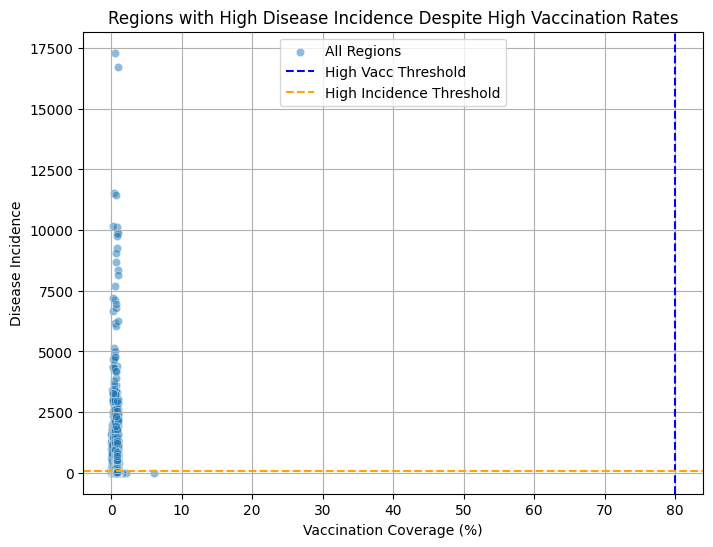

In [18]:
# Aggregate vaccination coverage per country-year
coverage_summary = (
    coverage_df.groupby(["code", "year"])["coverage"]
    .mean()
    .reset_index()
)

# Aggregate disease incidence per country-year
incidence_summary = (
    incidence_df.groupby(["code", "year"])["incidence_rate"]
    .mean()
    .reset_index()
)

# Merge datasets
merged_df = pd.merge(
    coverage_summary,
    incidence_summary,
    on=["code", "year"],
    how="inner"
)

# Define thresholds
high_vacc_threshold = 80
high_incidence_threshold = merged_df["incidence_rate"].quantile(0.75)  # top 25%

# Filter regions with high coverage & high incidence
outliers = merged_df[
    (merged_df["coverage"] >= high_vacc_threshold) &
    (merged_df["incidence_rate"] >= high_incidence_threshold)
]

print("🌍 Regions with high incidence despite high vaccination rates:")
print(outliers[["code", "year", "coverage", "incidence_rate"]])

# Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x="coverage", y="incidence_rate", alpha=0.5, label="All Regions")
sns.scatterplot(data=outliers, x="coverage", y="incidence_rate", color="red", s=100, label="High Vacc & High Incidence")
plt.axvline(high_vacc_threshold, color="blue", linestyle="--", label="High Vacc Threshold")
plt.axhline(high_incidence_threshold, color="orange", linestyle="--", label="High Incidence Threshold")
plt.title("Regions with High Disease Incidence Despite High Vaccination Rates")
plt.xlabel("Vaccination Coverage (%)")
plt.ylabel("Disease Incidence")
plt.legend()
plt.grid(True)
plt.show()

### Medium level (combination of different tables):

#### Is there a correlation between vaccine introduction and a decrease in disease cases?


📊 Average Cases Before vs After Vaccine Introduction:
  country                           vaccine  before_cases  after_cases  \
0     AND  aP (acellular pertussis) vaccine      0.304348     1.657754   
1     ARE  aP (acellular pertussis) vaccine     54.313953    54.246753   
2     ARG  aP (acellular pertussis) vaccine   1343.416667   485.032258   
3     ARM  aP (acellular pertussis) vaccine    183.198830    12.527273   
4     AUS  aP (acellular pertussis) vaccine   1117.555556  1329.174888   
5     AUT  aP (acellular pertussis) vaccine     37.880000   124.740157   
6     BEL  aP (acellular pertussis) vaccine     23.857143   146.543860   
7     BFA  aP (acellular pertussis) vaccine   1040.173653  5436.714286   
8     BGR  aP (acellular pertussis) vaccine    170.200000   227.597765   
9     BHR  aP (acellular pertussis) vaccine      5.875000     3.643902   

   reduction_%  
0  -444.690604  
1     0.123726  
2    63.895620  
3    93.161925  
4   -18.935912  
5  -229.303478  
6  -514.2556

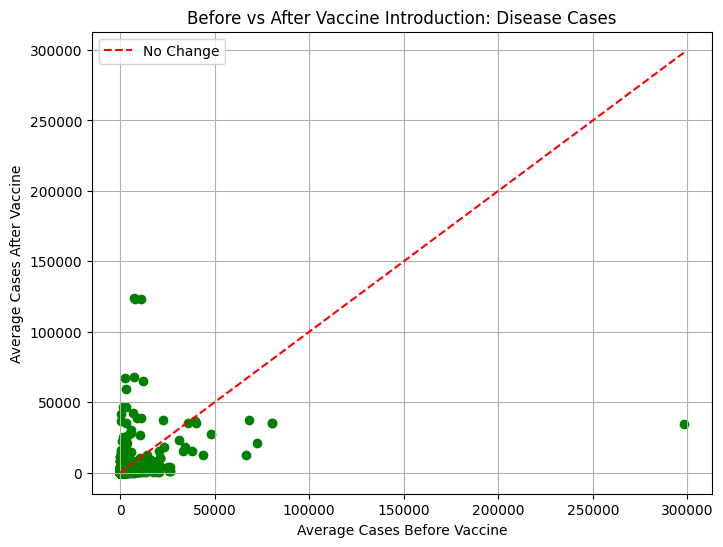

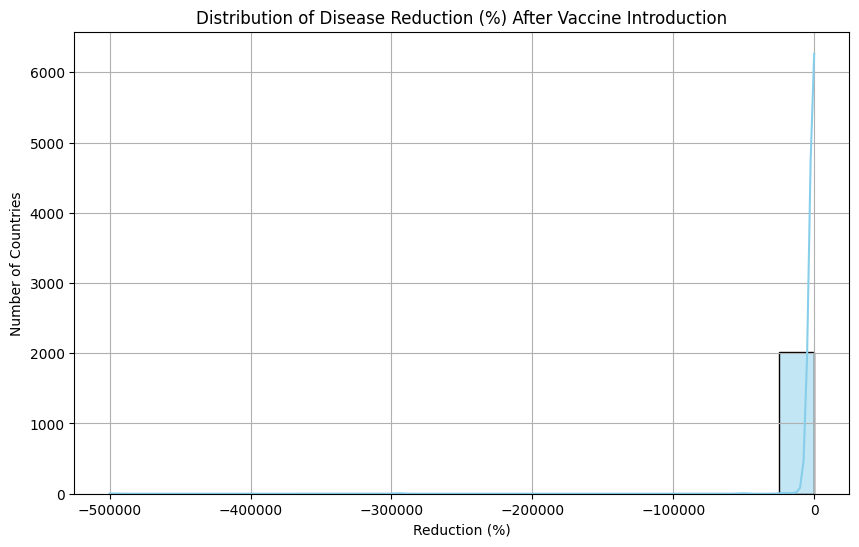

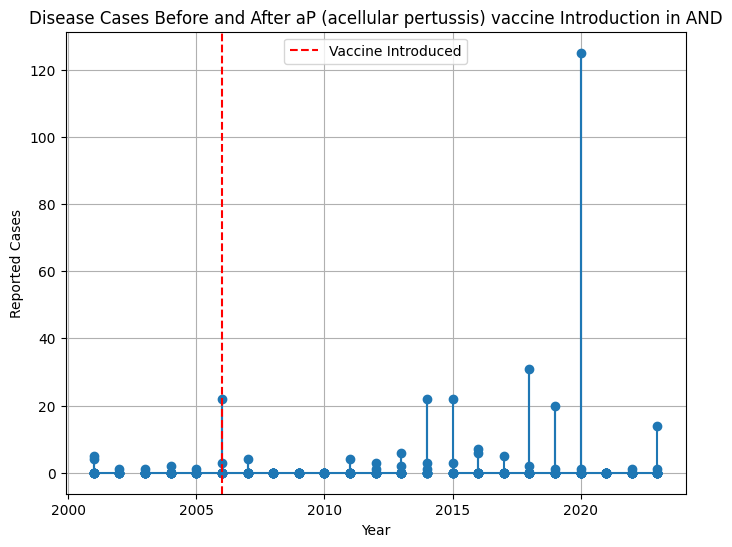

In [19]:
# Ensure consistent column names for merging
intro_df.rename(columns={"iso_3_code": "code", "description": "vaccine"}, inplace=True)

# Convert 'intro' column to numeric (1 for Yes, 0 for No)
intro_df["intro"] = intro_df["intro"].apply(lambda x: 1 if x == "Yes" else 0)


# Merge datasets
merged_df = pd.merge(
    cases_df,
    intro_df[["code","year","vaccine","intro"]], # Select relevant columns from intro_df
    on=["code", "year"],
    how="left" # Use a left merge to keep all cases data
)
merged_df["intro"] = merged_df["intro"].fillna(0) # Fill NaN intro values with 0 (no intro information)


# Compare before vs after introduction
results = []

# Only iterate over vaccines that are actually present in the merged data after merging
for vaccine in merged_df["vaccine"].dropna().unique():
    sub_df = merged_df[merged_df["vaccine"] == vaccine]

    # Find introduction year per country
    intro_years = sub_df[sub_df["intro"] == 1].groupby("code")["year"].min()

    for country, year in intro_years.items():
        country_cases = sub_df[sub_df["code"] == country]

        before = country_cases[country_cases["year"] < year]["cases"].mean()
        after = country_cases[country_cases["year"] >= year]["cases"].mean()

        if pd.notna(before) and pd.notna(after):
            reduction = ((before - after) / before) * 100 if before > 0 else None
            results.append({"country": country, "vaccine": vaccine, "before_cases": before, "after_cases": after, "reduction_%": reduction})

results_df = pd.DataFrame(results)

print("📊 Average Cases Before vs After Vaccine Introduction:")
print(results_df.head(10))


# Correlation Analysis (Check if results_df is not empty)
if not results_df.empty:
    # Calculate correlation between before and after cases
    # Need to drop rows with NaN in either column before calculating correlation
    corr_df = results_df.dropna(subset=["before_cases", "after_cases"])
    if not corr_df.empty:
      corr = corr_df["before_cases"].corr(corr_df["after_cases"])
      print(f"Correlation between cases before and after vaccine introduction: {corr:.2f}")

      # Scatter plot of before vs after cases
      plt.figure(figsize=(8,6))
      plt.scatter(results_df["before_cases"], results_df["after_cases"], color="green")
      # Add a line representing no change
      plt.plot([0, results_df["before_cases"].max()],
               [0, results_df["before_cases"].max()], 'r--', label="No Change")
      plt.xlabel("Average Cases Before Vaccine")
      plt.ylabel("Average Cases After Vaccine")
      plt.title("Before vs After Vaccine Introduction: Disease Cases")
      plt.legend()
      plt.grid(True)
      plt.show()

      # Histogram of percentage reduction
      plt.figure(figsize=(10,6))
      # Drop NaN values in reduction_% before plotting
      sns.histplot(results_df["reduction_%"].dropna(), bins=20, kde=True, color="skyblue")
      plt.title("Distribution of Disease Reduction (%) After Vaccine Introduction")
      plt.xlabel("Reduction (%)")
      plt.ylabel("Number of Countries")
      plt.grid(True)
      plt.show()
    else:
        print("\nNot enough data points to calculate correlation or generate plots.")


# Example Time Series Visualization (Check if results_df is not empty)
if not results_df.empty:
    # Get the first vaccine and country from the results
    example_vaccine = results_df["vaccine"].iloc[0]
    example_country = results_df["country"].iloc[0]

    # Filter the merged_df for the example vaccine and country
    example_data = merged_df[(merged_df["vaccine"] == example_vaccine) &
                             (merged_df["code"] == example_country)]

    # Find the introduction year for the example country and vaccine
    intro_year_example = intro_df[(intro_df["code"] == example_country) &
                                  (intro_df["vaccine"] == example_vaccine) &
                                  (intro_df["intro"] == 1)]["year"].min()


    plt.figure(figsize=(8,6))
    plt.plot(example_data["year"], example_data["cases"], marker="o")
    # Add a vertical line for the introduction year if found
    if pd.notna(intro_year_example):
        plt.axvline(intro_year_example, color="red", linestyle="--", label="Vaccine Introduced")
    plt.title(f"Disease Cases Before and After {example_vaccine} Introduction in {example_country}")
    plt.xlabel("Year")
    plt.ylabel("Reported Cases")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\nNo data available to plot example time series.")

#### What percentage of the target population has been covered by each vaccine?


📊 Percentage of target population covered by each vaccine:

                                  antigen_description  total_target  \
35       Influenza travellers (incl. Hajj pilgrimage)      377425.0   
39                          Malaria vaccine, 1st dose      653794.0   
40                          Malaria vaccine, 3rd dose      653794.0   
38           Japanese encephalitis vaccine, last dose    97378710.0   
32                                    Influenza other    77779776.0   
37            Japanese encephalitis vaccine, 1st dose    51435587.0   
47               Meningococcal ACYW conjugate vaccine     1974732.0   
6   Fractional inactivated polio-containing vaccin...   185154200.0   
34  Influenza residents living in long term care f...     3838101.0   
7   Fractional inactivated polio-containing vaccin...   184479595.0   

    total_doses  avg_reported_coverage  calculated_coverage_percent  
35    1685916.0              18.172772                   446.689011  
39     915833.0   

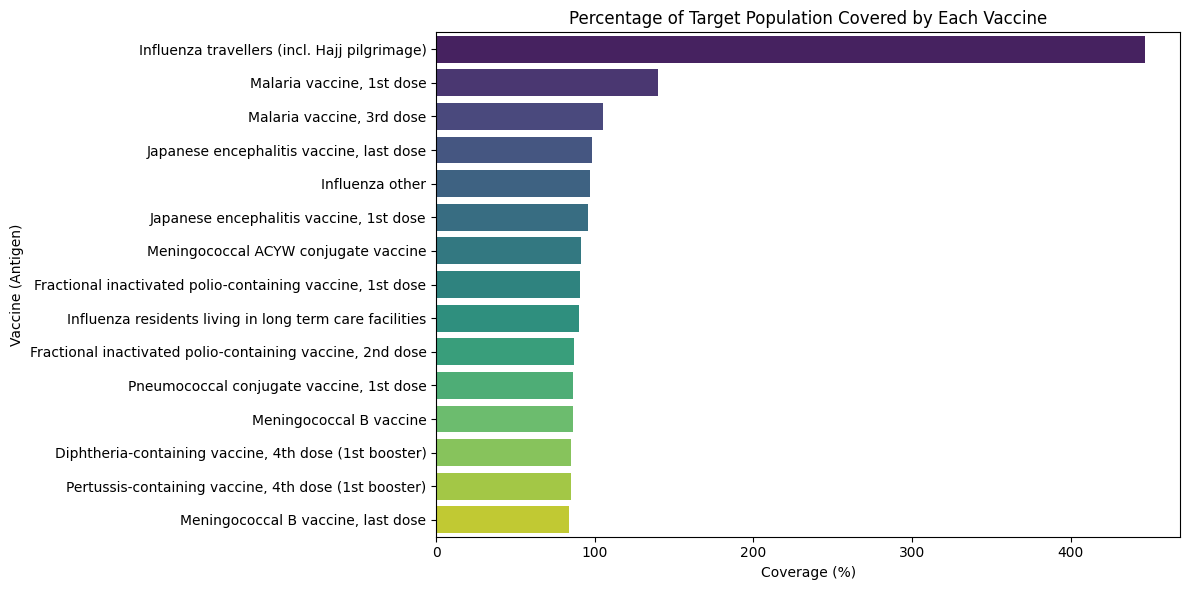

In [20]:
# Standardize column names
coverage_df.columns = coverage_df.columns.str.lower().str.replace(" ", "_")

# Ensure numeric
coverage_df["target_number"] = pd.to_numeric(coverage_df["target_number"], errors="coerce")
coverage_df["doses"] = pd.to_numeric(coverage_df["doses"], errors="coerce")

# Aggregate by vaccine (antigen)
vaccine_coverage = (
    coverage_df.groupby("antigen_description")
    .agg(
        total_target=("target_number", "sum"),
        total_doses=("doses", "sum"),
        avg_reported_coverage=("coverage", "mean")  # already reported in dataset
    )
    .reset_index()
)

# Calculate actual coverage %
vaccine_coverage["calculated_coverage_percent"] = (
    vaccine_coverage["total_doses"] / vaccine_coverage["total_target"] * 100
)

# Sort by coverage %
vaccine_coverage = vaccine_coverage.sort_values("calculated_coverage_percent", ascending=False)

print("📊 Percentage of target population covered by each vaccine:\n")
print(vaccine_coverage.head(10))

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(
    data=vaccine_coverage.head(15),  # show top 15 vaccines
    x="calculated_coverage_percent",
    y="antigen_description",
    palette="viridis"
)
plt.xlabel("Coverage (%)")
plt.ylabel("Vaccine (Antigen)")
plt.title("Percentage of Target Population Covered by Each Vaccine")
plt.tight_layout()
plt.show()


#### How does the vaccination schedule (e.g., booster doses) impact target population coverage?

📊 Average coverage by vaccine and dose type:

              antigen dose_type  coverage
0            15HPV1_F    Dose 1  0.460583
1            15HPV1_M    Dose 1  0.160670
2            15HPVC_F     Other  0.386976
3            15HPVC_M     Other  0.128201
4                 BCG     Other  0.841459
5             DIPHCV4   Booster  0.836758
6             DIPHCV5   Booster  0.805576
7             DIPHCV6   Booster  0.770704
8              DTPCV1    Dose 1  0.897343
9              DTPCV3    Dose 3  0.805080
10            FLU_ALL     Other  0.269153
11         FLU_CHILD1     Other  0.481668
12         FLU_CHILD2     Other  0.493103
13  FLU_CHRONIC_ADULT     Other  0.692310
14    FLU_CHRONIC_ALL     Other  0.661404


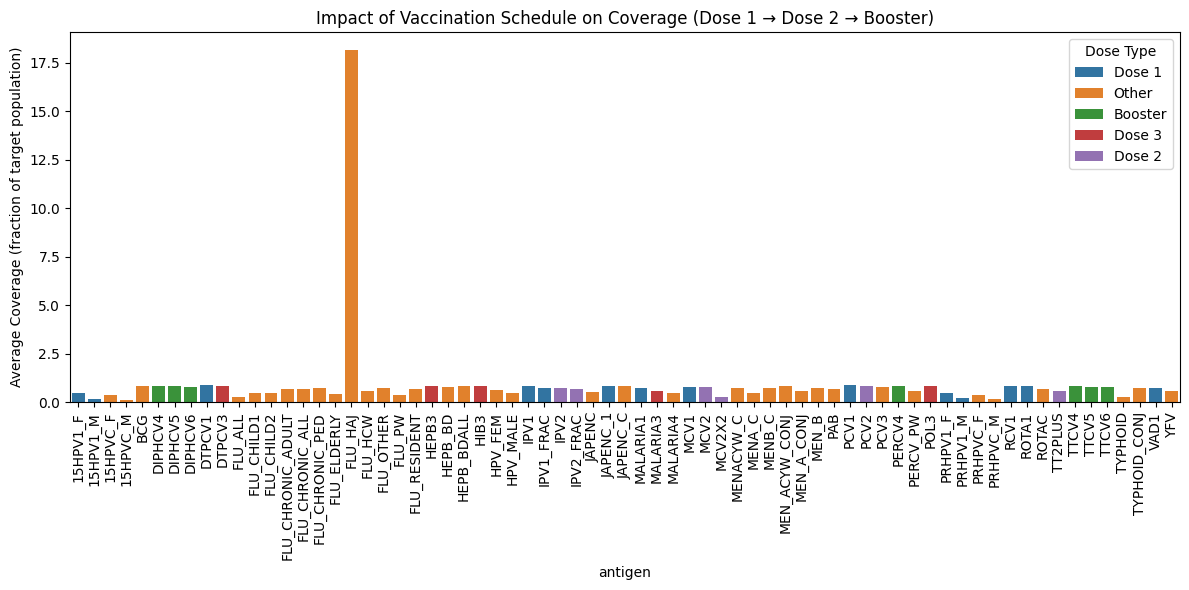

In [21]:
# Standardize column names
coverage_df.columns = coverage_df.columns.str.lower().str.replace(" ", "_")

# Identify dose type from antigen_description
def classify_dose(desc):
    if pd.isna(desc):
        return "Unknown"
    desc = str(desc).lower()
    if re.search(r"booster|revaccination", desc):
        return "Booster"
    elif re.search(r"dose[_ ]*1|1st|first", desc):
        return "Dose 1"
    elif re.search(r"dose[_ ]*2|2nd|second", desc):
        return "Dose 2"
    elif re.search(r"dose[_ ]*3|3rd|third", desc):
        return "Dose 3"
    else:
        return "Other"

coverage_df["dose_type"] = coverage_df["antigen_description"].apply(classify_dose)

# Average coverage by vaccine and dose type
dose_coverage = (
    coverage_df.groupby(["antigen", "dose_type"])["coverage"]
    .mean()
    .reset_index()
    .sort_values(["antigen", "dose_type"])
)

print("📊 Average coverage by vaccine and dose type:\n")
print(dose_coverage.head(15))

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(data=dose_coverage, x="antigen", y="coverage", hue="dose_type")
plt.xticks(rotation=90)
plt.ylabel("Average Coverage (fraction of target population)")
plt.title("Impact of Vaccination Schedule on Coverage (Dose 1 → Dose 2 → Booster)")
plt.legend(title="Dose Type")
plt.tight_layout()
plt.show()


#### How does vaccine coverage correlate with disease reduction for specific antigens?


In [22]:
from scipy.stats import pearsonr

# Standardize column names
coverage_df.columns = coverage_df.columns.str.lower().str.replace(" ", "_")
cases_df.columns = cases_df.columns.str.lower().str.replace(" ", "_")

# Example antigen → disease mapping (can be expanded based on dataset)
mapping = {
    "measles": "measles",
    "bcg": "tuberculosis",
    "polio": "poliomyelitis",
    "hepb": "hepatitis b",
    "dtp": "diphtheria",
    "mcv": "measles",
    "opv": "poliomyelitis",
    "ipv": "poliomyelitis"
}

# Apply mapping
coverage_df["mapped_disease"] = coverage_df["antigen"].str.lower().map(mapping)

# Merge coverage with disease cases
merged = coverage_df.merge(
    cases_df,
    left_on=["code", "year", "mapped_disease"],
    right_on=["code", "year", "disease"],
    how="inner"
)

# Correlation analysis
results = []
for disease in merged["mapped_disease"].dropna().unique():
    subset = merged[merged["mapped_disease"] == disease]
    if len(subset) > 10 and subset["coverage"].std() > 0 and subset["cases"].std() > 0:  # require enough data points and variation
        corr, pval = pearsonr(subset["coverage"], subset["cases"])
        results.append({"disease": disease, "correlation": corr, "p_value": pval})

if results: # Check if results is not empty
    correlation_df = pd.DataFrame(results).sort_values("correlation")

    print("📊 Correlation between vaccine coverage and disease reduction:\n")
    print(correlation_df)

    # --- Visualization ---
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(12,6))
    sns.lmplot(
        data=merged,
        x="coverage", y="cases",
        col="mapped_disease", col_wrap=2,
        scatter_kws={"alpha":0.5}, line_kws={"color":"red"}
    )
    plt.subplots_adjust(top=0.9)
    plt.suptitle("Coverage vs Disease Cases (per Antigen)")
    plt.show()
else:
    print("No significant correlation found for any disease with enough data.")

No significant correlation found for any disease with enough data.


#### What are the gaps in coverage for vaccines targeting high-priority diseases (e.g., TB, Hepatitis B)?

📉 Coverage gaps for high-priority vaccines (Top 15 countries):

    antigen code  coverage  coverage_gap
13      BCG  AUS  0.000000    100.000000
53      BCG  DEU  0.000000    100.000000
88      BCG  GUM  0.000000    100.000000
102     BCG  ITA  0.000000    100.000000
100     BCG  ISL  0.000000    100.000000
204     BCG  TTO  0.000000    100.000000
182     BCG  SMR  0.000000    100.000000
156     BCG  NZL  0.132954     99.867046
190     BCG  SWE  0.171628     99.828372
36      BCG  CHE  0.210000     99.790000
162     BCG  PLW  0.250000     99.750000
139     BCG  MNP  0.266250     99.733750
77      BCG  GBR  0.341429     99.658571
183     BCG  SOM  0.410939     99.589061
11      BCG  ASM  0.455000     99.545000


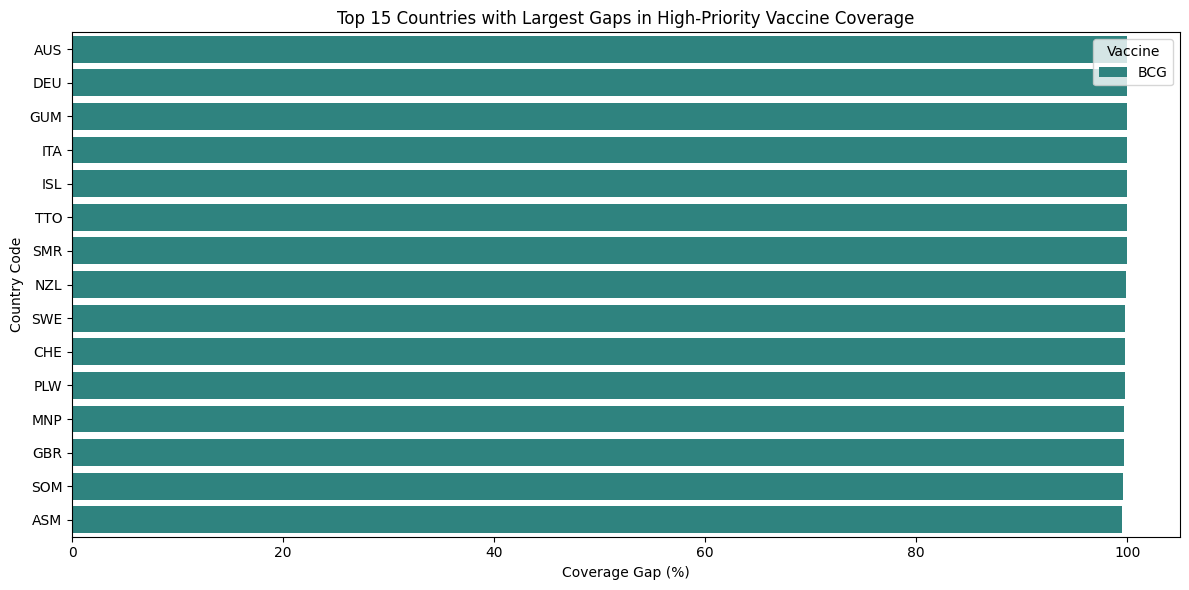

In [23]:
# Standardize columns
coverage_df.columns = coverage_df.columns.str.lower().str.replace(" ", "_")
coverage_df["coverage"] = pd.to_numeric(coverage_df["coverage"], errors="coerce")

# Define high-priority vaccines
priority_vaccines = ["bcg", "hepb", "mcv", "opv", "ipv", "dtp"]

# Filter only high-priority vaccines
priority_cov = coverage_df[coverage_df["antigen"].str.lower().isin(priority_vaccines)]

# Compute average coverage by vaccine and region
priority_summary = (
    priority_cov.groupby(["antigen", "code"])["coverage"]
    .mean()
    .reset_index()
)

# Calculate gap
priority_summary["coverage_gap"] = 100 - priority_summary["coverage"]

# Sort largest gaps
priority_gaps = priority_summary.sort_values("coverage_gap", ascending=False)

print("📉 Coverage gaps for high-priority vaccines (Top 15 countries):\n")
print(priority_gaps.head(15))

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(
    data=priority_gaps.head(15),
    x="coverage_gap",
    y="code",
    hue="antigen",
    dodge=True,
    palette="viridis"
)
plt.xlabel("Coverage Gap (%)")
plt.ylabel("Country Code")
plt.title("Top 15 Countries with Largest Gaps in High-Priority Vaccine Coverage")
plt.legend(title="Vaccine")
plt.tight_layout()
plt.show()

## SQL Database Setup with Python

In [30]:
# Installing ipython-sql
!pip install ipython-sql

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.2 MB/s eta 0:00:00


In [31]:
# Import Libraries:
import pandas as pd
import sqlite3

In [32]:
# Reload cleaned datasets (optional, ensures consistency)
coverage_df   = pd.read_csv("coverage_cleaned.csv")
incidence_df  = pd.read_csv("incidence_cleaned.csv")
cases_df      = pd.read_csv("cases_cleaned.csv")
intro_df      = pd.read_csv("vaccine_intro_cleaned.csv")
schedule_df   = pd.read_csv("schedule_cleaned.csv")

In [33]:
# Connect to SQLite database (or create new file)
conn = sqlite3.connect("vaccination_project.db")
cursor = conn.cursor()

In [34]:
# Load the extension:
%load_ext sql

In [35]:
# Connect to the SQLite Database
%sql sqlite:///vaccination_project.db

In [36]:
from sqlalchemy import create_engine, text

# Create SQLite database
engine = create_engine("sqlite:///vaccination_project.db")

#### Create Tables

In [37]:
# Create Tables
cursor.execute("""
CREATE TABLE IF NOT EXISTS coverage_data (
    Group_name TEXT,
    Code TEXT,
    Country_Name TEXT,
    Year INTEGER,
    Antigen TEXT,
    Antigen_description TEXT,
    Coverage_category TEXT,
    Coverage_category_description TEXT,
    Target_number INTEGER,
    Doses INTEGER,
    Coverage REAL
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS incidence_rate (
    Group_name TEXT,
    Code TEXT,
    Country_Name TEXT,
    Year INTEGER,
    Disease TEXT,
    Disease_description TEXT,
    Denominator INTEGER,
    Incidence_rate REAL
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS reported_cases (
    Group_name TEXT,
    Code TEXT,
    Country_Name TEXT,
    Year INTEGER,
    Disease TEXT,
    Disease_description TEXT,
    Cases INTEGER
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS vaccine_introduction (
    ISO_3_Code TEXT,
    Country_Name TEXT,
    WHO_Region TEXT,
    Year INTEGER,
    Description TEXT,
    Intro TEXT
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS vaccine_schedule (
    ISO_3_Code TEXT,
    Country_Name TEXT,
    WHO_Region TEXT,
    Year INTEGER,
    Vaccine_code TEXT,
    Vaccine_description TEXT,
    Schedule_rounds TEXT,
    Target_pop TEXT,
    Target_pop_description TEXT,
    Geoarea TEXT,
    Age_administered TEXT,
    Source_comment TEXT
);
""")

conn.commit()
print("✅ All tables created successfully!")

# Run a Test Query
sample = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in Database:")
print(sample)

✅ All tables created successfully!
Tables in Database:
                   name
0         coverage_data
1        incidence_rate
2        reported_cases
3  vaccine_introduction
4      vaccine_schedule


#### Normalized Database Schema:

In [38]:
# Open connection
with engine.connect() as conn:
    # Example: Countries Table
    conn.execute(text("""
    CREATE TABLE IF NOT EXISTS countries (
        country_id INTEGER PRIMARY KEY AUTOINCREMENT,
        iso_3_code TEXT UNIQUE,
        name TEXT,
        who_region TEXT
    );
    """))

    # Example: Years Table
    conn.execute(text("""
    CREATE TABLE IF NOT EXISTS years (
        year_id INTEGER PRIMARY KEY AUTOINCREMENT,
        year INTEGER UNIQUE
    );
    """))


In [39]:
# List of SQL statements
statements = [
"""
CREATE TABLE IF NOT EXISTS diseases (
    disease_id INTEGER PRIMARY KEY AUTOINCREMENT,
    code TEXT UNIQUE,
    description TEXT
);
""",
"""
CREATE TABLE IF NOT EXISTS vaccines (
    vaccine_id INTEGER PRIMARY KEY AUTOINCREMENT,
    code TEXT UNIQUE,
    description TEXT
);
""",
"""
CREATE TABLE IF NOT EXISTS coverage_data (
    coverage_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    year_id INTEGER,
    vaccine_id INTEGER,
    coverage_category TEXT,
    coverage_category_description TEXT,
    target_number INTEGER,
    doses INTEGER,
    coverage REAL,
    FOREIGN KEY (country_id) REFERENCES countries(country_id),
    FOREIGN KEY (year_id) REFERENCES years(year_id),
    FOREIGN KEY (vaccine_id) REFERENCES vaccines(vaccine_id)
);
""",
"""
CREATE TABLE IF NOT EXISTS incidence_rate (
    incidence_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    year_id INTEGER,
    disease_id INTEGER,
    denominator INTEGER,
    incidence_rate REAL,
    FOREIGN KEY (country_id) REFERENCES countries(country_id),
    FOREIGN KEY (year_id) REFERENCES years(year_id),
    FOREIGN KEY (disease_id) REFERENCES diseases(disease_id)
);
""",
"""
CREATE TABLE IF NOT EXISTS reported_cases (
    case_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    year_id INTEGER,
    disease_id INTEGER,
    cases INTEGER,
    FOREIGN KEY (country_id) REFERENCES countries(country_id),
    FOREIGN KEY (year_id) REFERENCES years(year_id),
    FOREIGN KEY (disease_id) REFERENCES diseases(disease_id)
);
""",
"""
CREATE TABLE IF NOT EXISTS vaccine_introduction (
    intro_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    year_id INTEGER,
    vaccine_id INTEGER,
    intro TEXT,
    FOREIGN KEY (country_id) REFERENCES countries(country_id),
    FOREIGN KEY (year_id) REFERENCES years(year_id),
    FOREIGN KEY (vaccine_id) REFERENCES vaccines(vaccine_id)
);
""",
"""
CREATE TABLE IF NOT EXISTS vaccine_schedule (
    schedule_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    year_id INTEGER,
    vaccine_id INTEGER,
    schedule_rounds TEXT,
    target_pop TEXT,
    target_pop_description TEXT,
    geoarea TEXT,
    age_administered TEXT,
    source_comment TEXT,
    FOREIGN KEY (country_id) REFERENCES countries(country_id),
    FOREIGN KEY (year_id) REFERENCES years(year_id),
    FOREIGN KEY (vaccine_id) REFERENCES vaccines(vaccine_id)
);
"""
]

# Execute each statement separately
with engine.connect() as conn:
    for stmt in statements:
        conn.execute(text(stmt))

print("All tables created successfully!")


All tables created successfully!


##### Data Integrity: Implement primary and foreign keys to ensure referential integrity.


In [40]:
# Define all tables with primary & foreign keys
statements = [
"""
CREATE TABLE IF NOT EXISTS countries (
    country_id INTEGER PRIMARY KEY AUTOINCREMENT,
    iso_3_code TEXT UNIQUE,
    name TEXT,
    who_region TEXT
);
""",
"""
CREATE TABLE IF NOT EXISTS years (
    year_id INTEGER PRIMARY KEY AUTOINCREMENT,
    year INTEGER UNIQUE
);
""",
"""
CREATE TABLE IF NOT EXISTS diseases (
    disease_id INTEGER PRIMARY KEY AUTOINCREMENT,
    code TEXT UNIQUE,
    description TEXT
);
""",
"""
CREATE TABLE IF NOT EXISTS vaccines (
    vaccine_id INTEGER PRIMARY KEY AUTOINCREMENT,
    code TEXT UNIQUE,
    description TEXT
);
""",
"""
CREATE TABLE IF NOT EXISTS coverage_data (
    coverage_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    year_id INTEGER,
    vaccine_id INTEGER,
    coverage_category TEXT,
    coverage_category_description TEXT,
    target_number INTEGER,
    doses INTEGER,
    coverage REAL,
    FOREIGN KEY (country_id) REFERENCES countries(country_id) ON DELETE CASCADE,
    FOREIGN KEY (year_id) REFERENCES years(year_id) ON DELETE CASCADE,
    FOREIGN KEY (vaccine_id) REFERENCES vaccines(vaccine_id) ON DELETE CASCADE
);
""",
"""
CREATE TABLE IF NOT EXISTS incidence_rate (
    incidence_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    year_id INTEGER,
    disease_id INTEGER,
    denominator INTEGER,
    incidence_rate REAL,
    FOREIGN KEY (country_id) REFERENCES countries(country_id) ON DELETE CASCADE,
    FOREIGN KEY (year_id) REFERENCES years(year_id) ON DELETE CASCADE,
    FOREIGN KEY (disease_id) REFERENCES diseases(disease_id) ON DELETE CASCADE
);
""",
"""
CREATE TABLE IF NOT EXISTS reported_cases (
    case_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    year_id INTEGER,
    disease_id INTEGER,
    cases INTEGER,
    FOREIGN KEY (country_id) REFERENCES countries(country_id) ON DELETE CASCADE,
    FOREIGN KEY (year_id) REFERENCES years(year_id) ON DELETE CASCADE,
    FOREIGN KEY (disease_id) REFERENCES diseases(disease_id) ON DELETE CASCADE
);
""",
"""
CREATE TABLE IF NOT EXISTS vaccine_introduction (
    intro_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    year_id INTEGER,
    vaccine_id INTEGER,
    intro TEXT,
    FOREIGN KEY (country_id) REFERENCES countries(country_id) ON DELETE CASCADE,
    FOREIGN KEY (year_id) REFERENCES years(year_id) ON DELETE CASCADE,
    FOREIGN KEY (vaccine_id) REFERENCES vaccines(vaccine_id) ON DELETE CASCADE
);
""",
"""
CREATE TABLE IF NOT EXISTS vaccine_schedule (
    schedule_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    year_id INTEGER,
    vaccine_id INTEGER,
    schedule_rounds TEXT,
    target_pop TEXT,
    target_pop_description TEXT,
    geoarea TEXT,
    age_administered TEXT,
    source_comment TEXT,
    FOREIGN KEY (country_id) REFERENCES countries(country_id) ON DELETE CASCADE,
    FOREIGN KEY (year_id) REFERENCES years(year_id) ON DELETE CASCADE,
    FOREIGN KEY (vaccine_id) REFERENCES vaccines(vaccine_id) ON DELETE CASCADE
);
"""
]

# Execute all statements one by one
with engine.connect() as conn:
    for stmt in statements:
        conn.execute(text(stmt))

print("Normalized schema with Primary & Foreign Keys created successfully!")

Normalized schema with Primary & Foreign Keys created successfully!


# **Conclusion -**

## These are a points of Conclusion -
1.   **Summary of Key Findings:**

*   The project successfully analyzed global vaccination data, uncovering trends and relationships between vaccination rates and disease incidence.
*   The analysis identified areas with low vaccination coverage, which can be prioritized for resource allocation.
*   It provided data-driven insights on the effectiveness of vaccination programs, highlighting diseases where efforts may need to be strengthened.

2.   **Achievement of Project Objectives:**

*   The project successfully implemented a data pipeline using Python for cleaning, SQL for data storage, and Power BI for visualization.
*   The creation of interactive dashboards allows for easy exploration of the data and provides valuable insights to stakeholders in public health.

3.   **Future Scope/Next Steps:**

*   The project can be expanded by incorporating additional data sources, such as socioeconomic factors or climate data, to provide a more holistic view.
*   Predictive modeling could be used to forecast future vaccination needs or disease outbreaks.
*   The dashboards can be made available to the public to promote greater transparency and understanding of global health trends.







